In [4]:
import tensorflow as tf
import pandas as pd
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import spacy
import sys
from spacy.lang.en import English
import en_core_web_sm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

In [5]:
df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

df = df[['headline', 'is_sarcastic']]

df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
df['headline'] = df.headline.apply(lambda x:x.lower())  # convert all words in headline into lower case 
df['headline'] = df.headline.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))  # remove all punctuations in headline

In [7]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/omkar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
nlp = en_core_web_sm.load()
parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))


def tokenize(text):
    """this function is to tokenize the headline into a list of individual words"""
    lda_tokens = []
    tokens = parser(text)  # need to use parser for python to treat the list as words
    for token in tokens:
        if token.orth_.isspace():  # to ignore any whitespaces in the headline, so that token list does not contain whitespaces 
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)   # tokens (headlines) are already in lowercase
    return lda_tokens


def get_lemma(word):
    """this function is to lemmatize the words in a headline into its root form"""
    lemma = wn.morphy(word)  # converts the word into root form from wordnet
    if lemma is None:
        return word
    else:
        return lemma
    

def prepare_text_for_lda(text):
    tokens = tokenize(text)  # parse and tokenize the headline into a list of words
    tokens = [token for token in tokens if len(token) > 4]  # remove headlines with only length of 4 words or less
    tokens = [token for token in tokens if token not in en_stop]  # remove stopwords in the headline
    tokens = [get_lemma(token) for token in tokens]  # lemmatize the words in the headline
    return tokens

In [9]:
text_data = []
for headline in df.headline:
    tokens = prepare_text_for_lda(headline)
    text_data.append(tokens)

In [10]:
from gensim import corpora
import pickle

dictionary = corpora.Dictionary(text_data)  # Convert all headlines into a corpus of words, with each word as a token
corpus = [dictionary.doc2bow(text) for text in text_data]  # Convert each headline (a list of words) into the bag-of-words format. (Word ID, Count of word)
pickle.dump(corpus, open('corpus.pkl', 'wb'))  
dictionary.save('dictionary.gensim') 

In [11]:
import gensim

NUM_TOPICS = [3, 5, 10]
# passes: Number of passes through the corpus during training
# alpha: priori on the distribution of the topics in each document.
# The higher the alpha, the higher the likelihood that document contains a wide range of topics, vice versa. 
# beta: priori on the distribution of the words in each topic.
# The higher the beta, the higher the likelihood that topic contains a wide range of words, vice versa.
# we do not alter / fine tune the default values of alpha and beta
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS[1], id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.014*"house" + 0.011*"white" + 0.007*"things" + 0.006*"going" + 0.006*"office"'),
 (1,
  '0.007*"police" + 0.006*"school" + 0.005*"thing" + 0.005*"first" + 0.005*"american"'),
 (2,
  '0.011*"woman" + 0.009*"world" + 0.008*"parent" + 0.007*"change" + 0.005*"first"'),
 (3,
  '0.052*"trump" + 0.015*"donald" + 0.010*"clinton" + 0.006*"campaign" + 0.006*"court"'),
 (4,
  '0.016*"report" + 0.009*"nation" + 0.007*"woman" + 0.006*"american" + 0.006*"find"')]

In [12]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.017*"trump" + 0.006*"donald" + 0.005*"american" + 0.005*"would" + 0.005*"study"'),
 (1,
  '0.010*"trump" + 0.007*"school" + 0.006*"child" + 0.006*"clinton" + 0.006*"woman"'),
 (2,
  '0.008*"house" + 0.007*"woman" + 0.006*"trump" + 0.006*"white" + 0.006*"change"')]

In [13]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=5)
topics


[(0,
  '0.016*"things" + 0.010*"break" + 0.009*"claim" + 0.009*"couple" + 0.008*"around"'),
 (1,
  '0.023*"could" + 0.017*"party" + 0.016*"election" + 0.011*"million" + 0.010*"reason"'),
 (2,
  '0.013*"video" + 0.012*"kill" + 0.012*"shooting" + 0.012*"congress" + 0.012*"show"'),
 (3,
  '0.014*"court" + 0.013*"going" + 0.010*"supreme" + 0.009*"enough" + 0.009*"better"'),
 (4,
  '0.102*"trump" + 0.030*"donald" + 0.019*"clinton" + 0.013*"obama" + 0.011*"hillary"'),
 (5,
  '0.024*"school" + 0.019*"report" + 0.016*"friend" + 0.015*"study" + 0.015*"child"'),
 (6,
  '0.019*"parent" + 0.014*"family" + 0.013*"never" + 0.013*"watch" + 0.013*"little"'),
 (7,
  '0.025*"change" + 0.011*"climate" + 0.010*"introduce" + 0.010*"plan" + 0.009*"tweet"'),
 (8,
  '0.025*"house" + 0.021*"white" + 0.011*"release" + 0.011*"woman" + 0.010*"thing"'),
 (9,
  '0.020*"woman" + 0.014*"american" + 0.013*"every" + 0.012*"getting" + 0.011*"story"')]

In [14]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [15]:
lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
lda_display3 = pyLDAvis.gensim.prepare(lda3, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display3)


In [16]:
lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_display10 = pyLDAvis.gensim.prepare(lda10, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display10)

In [17]:
from numpy import mean

sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda10[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 10 clusters:')
print('\nFor Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda10[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

For LDA model with 10 clusters:

For Sarcastic Dataset:
[(0, 0.013256082), (1, 0.07590768), (2, 0.013256086), (3, 0.3999882), (4, 0.013256168), (5, 0.013256087), (6, 0.013256082), (7, 0.013256094), (8, 0.43131128), (9, 0.013256269)]

For Non-sarcastic Dataset:
[(0, 0.013473262), (1, 0.093551196), (2, 0.013473266), (3, 0.47158346), (4, 0.013473331), (5, 0.013473268), (6, 0.013473262), (7, 0.013473278), (8, 0.34055227), (9, 0.013473409)]


In [18]:
sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 5 clusters:')
print('For Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])


For LDA model with 5 clusters:
For Sarcastic Dataset:
[(0, 0.023584116), (1, 0.08550457), (2, 0.52118534), (3, 0.023917072), (4, 0.34580886)]

For Non-sarcastic Dataset:
[(0, 0.023914754), (1, 0.10285294), (2, 0.4132312), (3, 0.024235424), (4, 0.43576562)]


In [19]:
sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda3[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 3 clusters:')
print('For Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda3[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

For LDA model with 3 clusters:
For Sarcastic Dataset:
[(0, 0.22963925), (1, 0.08284527), (2, 0.68751544)]

For Non-sarcastic Dataset:
[(0, 0.2515491), (1, 0.09482261), (2, 0.6536283)]


Prediction of Sarcasm in Headlines using Deep Learning Methods
===============================================================

Architectures:
1. RNN with Gated Recurrent Units (Lasso Regularization, Dropout, Batch Normalization)
2. RNN with Gated Recurrent Units (Ridge Regularization, Dropout, Batch Normalization)
3. RNN with Long Short-Term Memory Units (Lasso Regularization, Dropout, Batch Normalization)
4. RNN with Long Short-Term Memory Units (Ridge Regularization, Dropout, Batch Normalization)
5. CNN with Conv1D
6. Combination of CNN-RNN (LSTM)

The output from the CNN with Conv1D is used as input for the RNN with LSTM (Lasso Regularization, Dropout, Batch Normalization) model.

These architectures represent different recurrent neural network (RNN) and convolutional neural network (CNN) configurations with various regularization techniques, including Lasso and Ridge regularization, as well as dropout and batch normalization. 


In [20]:
train_data, test_data = train_test_split(df[['headline', 'is_sarcastic']], test_size=0.1)  # randomly splitting 10% of dataset to be training dataset 

training_sentences = list(train_data['headline'])
training_labels = list(train_data['is_sarcastic'])

testing_sentences = list(test_data['headline'])
testing_labels = list(test_data['is_sarcastic'])
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [21]:
vocab_size = 10000   # limit vector of words to the top 10,000 words
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [22]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [23]:
# Model Definition with BiRNN (GRU)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

2023-07-17 18:30:55.829529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 18:30:55.831225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 18:30:55.832093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [24]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10


2023-07-17 18:31:23.892033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 18:31:23.893415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 18:31:23.895159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

375/376 [============================>.] - ETA: 0s - loss: 0.8254 - accuracy: 0.7869

2023-07-17 18:31:39.591374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 18:31:39.592277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 18:31:39.593426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

376/376 [==============================] - 17s 36ms/step - loss: 0.8245 - accuracy: 0.7871 - val_loss: 0.5054 - val_accuracy: 0.8428
Epoch 2/10
376/376 [==============================] - 13s 34ms/step - loss: 0.2898 - accuracy: 0.9017 - val_loss: 0.4307 - val_accuracy: 0.8289
Epoch 3/10
376/376 [==============================] - 13s 35ms/step - loss: 0.2117 - accuracy: 0.9320 - val_loss: 0.4017 - val_accuracy: 0.8495
Epoch 4/10
376/376 [==============================] - 13s 35ms/step - loss: 0.1592 - accuracy: 0.9551 - val_loss: 0.5618 - val_accuracy: 0.8289
Epoch 5/10
376/376 [==============================] - 13s 35ms/step - loss: 0.1275 - accuracy: 0.9682 - val_loss: 0.5321 - val_accuracy: 0.8420
Epoch 6/10
376/376 [==============================] - 14s 36ms/step - loss: 0.0965 - accuracy: 0.9774 - val_loss: 0.5930 - val_accuracy: 0.8326
Epoch 7/10
376/376 [==============================] - 14s 36ms/step - loss: 0.0820 - accuracy: 0.9845 - val_loss: 0.6454 - val_accuracy: 0.8386
Epo

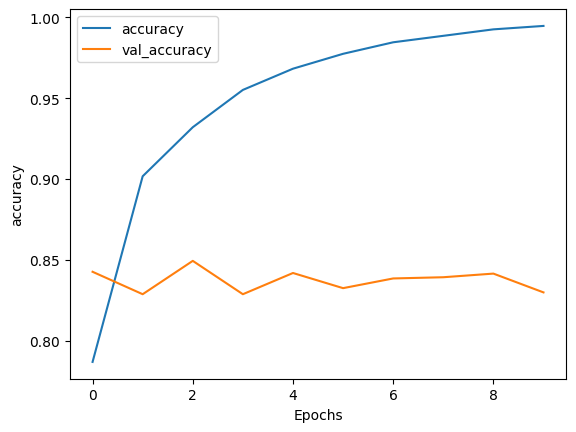

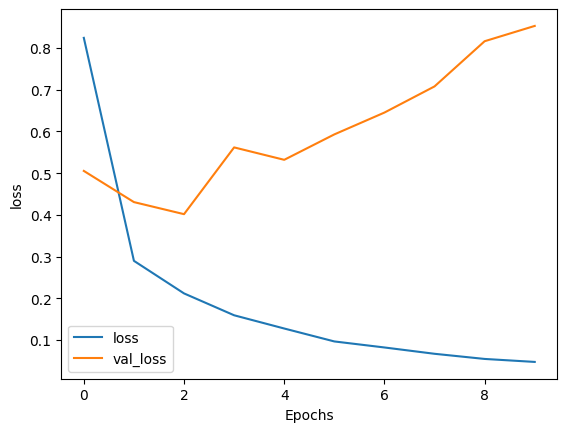

In [25]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [26]:

# Model Definition with BiRNN (GRU)
# with L2 Ridge Regularization
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

2023-07-17 18:54:49.006675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 18:54:49.009321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 18:54:49.011021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 100)               6500      
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [27]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10


2023-07-17 18:55:06.044507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 18:55:06.048391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 18:55:06.051448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

375/376 [============================>.] - ETA: 0s - loss: 0.5211 - accuracy: 0.7825

2023-07-17 18:55:22.932776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 18:55:22.933940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 18:55:22.935434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

376/376 [==============================] - 18s 38ms/step - loss: 0.5209 - accuracy: 0.7825 - val_loss: 0.5152 - val_accuracy: 0.8195
Epoch 2/10
376/376 [==============================] - 14s 37ms/step - loss: 0.2624 - accuracy: 0.9007 - val_loss: 1.9259 - val_accuracy: 0.5859
Epoch 3/10
376/376 [==============================] - 14s 37ms/step - loss: 0.1795 - accuracy: 0.9357 - val_loss: 0.6995 - val_accuracy: 0.7623
Epoch 4/10
376/376 [==============================] - 12s 33ms/step - loss: 0.1243 - accuracy: 0.9578 - val_loss: 3.2971 - val_accuracy: 0.5163
Epoch 5/10
376/376 [==============================] - 13s 34ms/step - loss: 0.0895 - accuracy: 0.9707 - val_loss: 1.0272 - val_accuracy: 0.7480
Epoch 6/10
376/376 [==============================] - 14s 38ms/step - loss: 0.0658 - accuracy: 0.9795 - val_loss: 2.0501 - val_accuracy: 0.6780
Epoch 7/10
376/376 [==============================] - 13s 36ms/step - loss: 0.0543 - accuracy: 0.9837 - val_loss: 0.8117 - val_accuracy: 0.8285
Epo

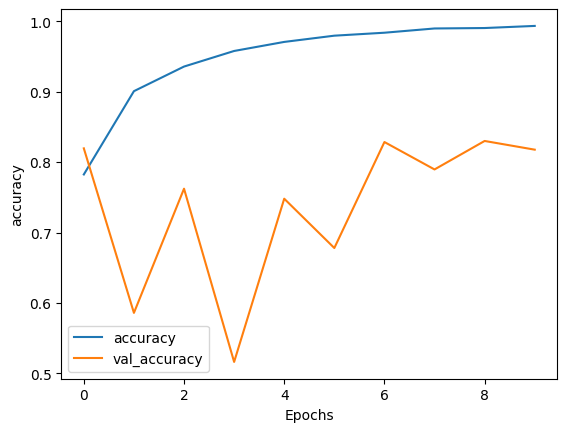

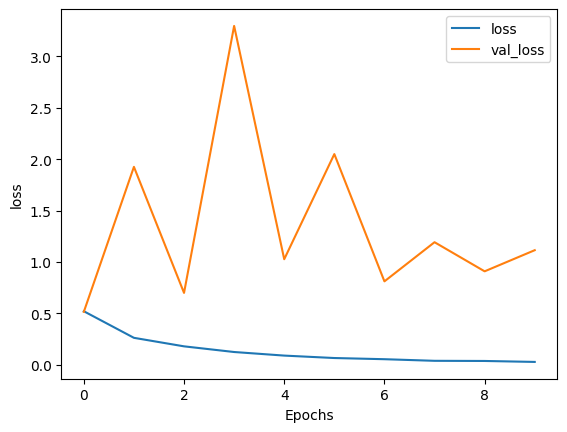

In [28]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

## RNN with LSTM Architecture

For the prediction of sarcasm in headlines, we will utilize the RNN (Recurrent Neural Network) with LSTM (Long Short-Term Memory) architecture. We will consider two variations of this architecture:

1. RNN with LSTM (with Lasso Regularization, Dropout, Batch Normalization)
2. RNN with LSTM (with Ridge Regularization, Dropout, Batch Normalization)

The LSTM units in these architectures are capable of capturing long-range dependencies in sequential data, making them suitable for modeling natural language patterns.

To improve the performance and generalization of the models, we incorporate additional techniques:

- Lasso Regularization: Lasso regularization helps in reducing overfitting by adding a penalty term to the loss function, encouraging sparsity in the learned weights.
- Ridge Regularization: Ridge regularization also addresses overfitting by adding a penalty term, but it encourages small weights without promoting sparsity.
- Dropout: Dropout is applied to randomly deactivate neurons during training, preventing over-reliance on specific features and enhancing the robustness of the model.
- Batch Normalization: Batch normalization normalizes the inputs to each layer, reducing the internal covariate shift and aiding in faster training and better convergence.

By combining these techniques with the LSTM architecture, we aim to enhance the model's ability to capture and understand sarcasm in headlines.



In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

2023-07-17 23:26:05.780637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 23:26:05.783312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 23:26:05.787366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 100)               6500      
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [30]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10


2023-07-17 23:26:38.289030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 23:26:38.290823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 23:26:38.292617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

376/376 [==============================] - ETA: 0s - loss: 0.8255 - accuracy: 0.7945

2023-07-17 23:26:55.226652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 23:26:55.227654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 23:26:55.228689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

376/376 [==============================] - 18s 41ms/step - loss: 0.8255 - accuracy: 0.7945 - val_loss: 0.5891 - val_accuracy: 0.6889
Epoch 2/10
376/376 [==============================] - 16s 42ms/step - loss: 0.2855 - accuracy: 0.9012 - val_loss: 0.3748 - val_accuracy: 0.8510
Epoch 3/10
376/376 [==============================] - 13s 35ms/step - loss: 0.2059 - accuracy: 0.9373 - val_loss: 0.4514 - val_accuracy: 0.8424
Epoch 4/10
376/376 [==============================] - 14s 36ms/step - loss: 0.1650 - accuracy: 0.9537 - val_loss: 0.5021 - val_accuracy: 0.8390
Epoch 5/10
376/376 [==============================] - 14s 38ms/step - loss: 0.1216 - accuracy: 0.9708 - val_loss: 0.5885 - val_accuracy: 0.8278
Epoch 6/10
376/376 [==============================] - 14s 38ms/step - loss: 0.0977 - accuracy: 0.9769 - val_loss: 0.6057 - val_accuracy: 0.8326
Epoch 7/10
376/376 [==============================] - 15s 41ms/step - loss: 0.0805 - accuracy: 0.9836 - val_loss: 0.6974 - val_accuracy: 0.8274
Epo

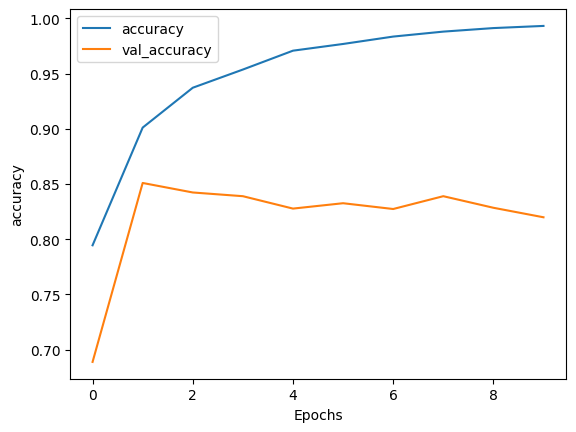

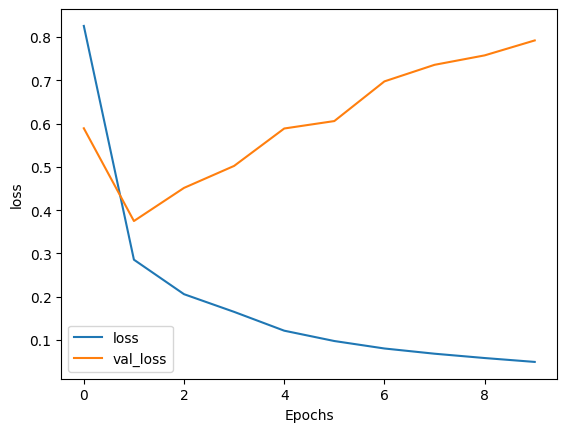

In [31]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

In [32]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 100)               6500      
                                                                 
 batch_normalization_3 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                

2023-07-17 23:29:37.972644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 23:29:37.974467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 23:29:37.975623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [33]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10


2023-07-17 23:29:52.673994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 23:29:52.677544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 23:29:52.681190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

376/376 [==============================] - ETA: 0s - loss: 0.4832 - accuracy: 0.8047

2023-07-17 23:30:11.763466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 23:30:11.764546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 23:30:11.766105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

376/376 [==============================] - 20s 46ms/step - loss: 0.4832 - accuracy: 0.8047 - val_loss: 0.4910 - val_accuracy: 0.8143
Epoch 2/10
376/376 [==============================] - 16s 42ms/step - loss: 0.2564 - accuracy: 0.9010 - val_loss: 0.3715 - val_accuracy: 0.8383
Epoch 3/10
376/376 [==============================] - 16s 42ms/step - loss: 0.1791 - accuracy: 0.9361 - val_loss: 0.4166 - val_accuracy: 0.8428
Epoch 4/10
376/376 [==============================] - 16s 44ms/step - loss: 0.1274 - accuracy: 0.9571 - val_loss: 0.4610 - val_accuracy: 0.8401
Epoch 5/10
376/376 [==============================] - 19s 51ms/step - loss: 0.0924 - accuracy: 0.9707 - val_loss: 0.5349 - val_accuracy: 0.8360
Epoch 6/10
376/376 [==============================] - 17s 45ms/step - loss: 0.0699 - accuracy: 0.9806 - val_loss: 0.6463 - val_accuracy: 0.8341
Epoch 7/10
376/376 [==============================] - 17s 45ms/step - loss: 0.0593 - accuracy: 0.9834 - val_loss: 0.7038 - val_accuracy: 0.8379
Epo

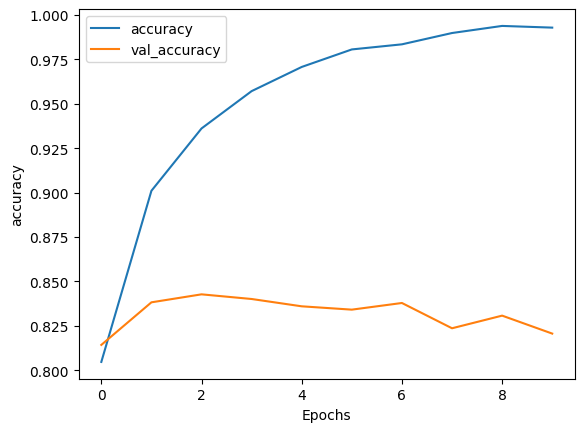

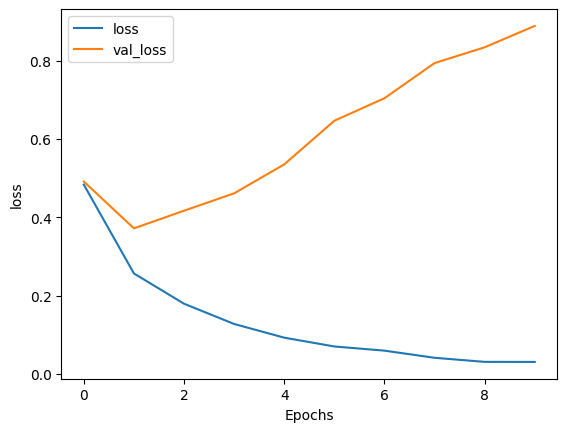

In [34]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

## CNN with Conv1D Architecture

For the prediction of sarcasm in headlines, we will utilize the CNN (Convolutional Neural Network) with Conv1D architecture. 

Convolutional neural networks are primarily known for their effectiveness in computer vision tasks, but they can also be applied to text data by treating it as one-dimensional sequences. Conv1D performs 1D convolutions over the text input, capturing local patterns and features.

The architecture for sarcasm prediction using CNN with Conv1D typically involves the following components:

1. Convolutional Layers: These layers apply multiple filters to the input data, extracting different features at various levels of abstraction. The filters slide across the input text, performing convolutions to capture local patterns.

2. Pooling Layers: After convolutions, pooling layers are used to downsample the output, reducing the dimensionality and extracting the most important information. Common pooling methods include max pooling or average pooling.

3. Fully Connected Layers: Following the convolutional and pooling layers, fully connected layers are added to perform high-level feature extraction and prediction. These layers aggregate information from the previous layers and map it to the desired output.





In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_8 (Dense)             (None, 100)               12900     
                                                                 
 batch_normalization_4 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 100)              

In [36]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10
376/376 [==============================] - 5s 11ms/step - loss: 0.4909 - accuracy: 0.7949 - val_loss: 0.9835 - val_accuracy: 0.5623
Epoch 2/10
376/376 [==============================] - 4s 10ms/step - loss: 0.2814 - accuracy: 0.8913 - val_loss: 0.4426 - val_accuracy: 0.8113
Epoch 3/10
376/376 [==============================] - 3s 9ms/step - loss: 0.2219 - accuracy: 0.9175 - val_loss: 5.5577 - val_accuracy: 0.4377
Epoch 4/10
376/376 [==============================] - 3s 8ms/step - loss: 0.1895 - accuracy: 0.9347 - val_loss: 6.5658 - val_accuracy: 0.4377
Epoch 5/10
376/376 [==============================] - 3s 8ms/step - loss: 0.1628 - accuracy: 0.9454 - val_loss: 5.4818 - val_accuracy: 0.4384
Epoch 6/10
376/376 [==============================] - 3s 8ms/step - loss: 0.1419 - accuracy: 0.9579 - val_loss: 0.4607 - val_accuracy: 0.8282
Epoch 7/10
376/376 [==============================] - 3s 8ms/step - loss: 0.1186 - accuracy: 0.9676 - val_loss: 1.2009 - val_accuracy: 0.7570
Epoc

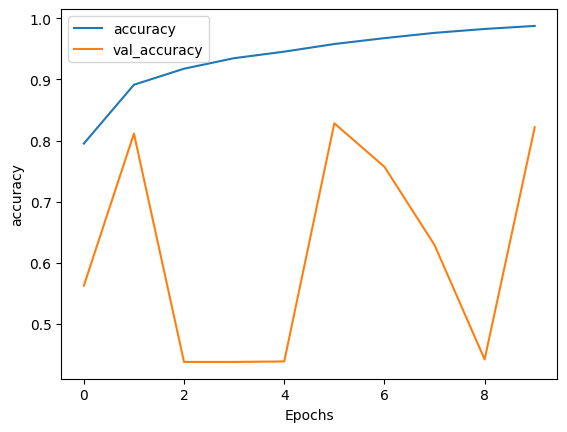

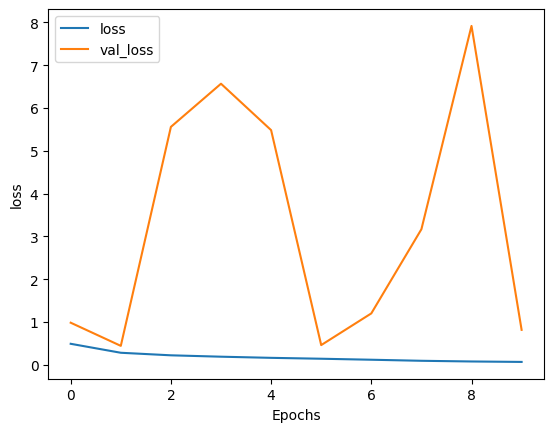

In [37]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')
plt.show()

## Combination of CNN-RNN (LSTM) Architecture

For the prediction of sarcasm in headlines, we will utilize a combination of the CNN (Convolutional Neural Network) and RNN (Recurrent Neural Network) architectures. Specifically, we will use a CNN with Conv1D to extract relevant features from the input headlines, and the output from the CNN will be used as input for an RNN with LSTM (Long Short-Term Memory).







In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 1, activation='relu'),
    tf.keras.layers.MaxPooling1D(2, padding="same"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 128)          2176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 128)          0         
 )                                                               
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 100)               6500      
                                                                 
 dropout_5 (Dropout)         (None, 100)              

2023-07-17 23:40:08.258247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 23:40:08.261189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 23:40:08.262594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [40]:
num_epochs = 10

history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))


Epoch 1/10


2023-07-17 23:41:03.446329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 23:41:03.447347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 23:41:03.448646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

374/376 [============================>.] - ETA: 0s - loss: 1.1458 - accuracy: 0.7058

2023-07-17 23:41:15.438088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-17 23:41:15.439015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-17 23:41:15.440052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

376/376 [==============================] - 13s 28ms/step - loss: 1.1430 - accuracy: 0.7064 - val_loss: 0.4754 - val_accuracy: 0.8405
Epoch 2/10
376/376 [==============================] - 11s 29ms/step - loss: 0.4261 - accuracy: 0.8832 - val_loss: 0.4374 - val_accuracy: 0.8502
Epoch 3/10
376/376 [==============================] - 13s 35ms/step - loss: 0.3459 - accuracy: 0.9215 - val_loss: 0.4745 - val_accuracy: 0.8398
Epoch 4/10
376/376 [==============================] - 11s 29ms/step - loss: 0.3016 - accuracy: 0.9396 - val_loss: 0.4785 - val_accuracy: 0.8405
Epoch 5/10
376/376 [==============================] - 11s 28ms/step - loss: 0.2712 - accuracy: 0.9526 - val_loss: 0.5153 - val_accuracy: 0.8274
Epoch 6/10
376/376 [==============================] - 13s 34ms/step - loss: 0.2446 - accuracy: 0.9611 - val_loss: 0.5409 - val_accuracy: 0.8297
Epoch 7/10
376/376 [==============================] - 18s 47ms/step - loss: 0.2288 - accuracy: 0.9666 - val_loss: 0.5797 - val_accuracy: 0.8356
Epo

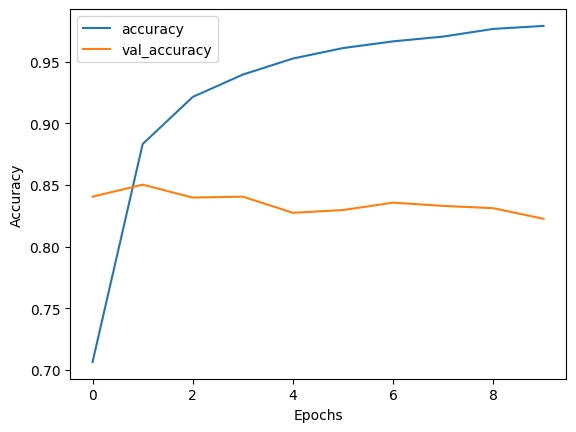

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend(['accuracy', 'val_accuracy'])

plt.show()


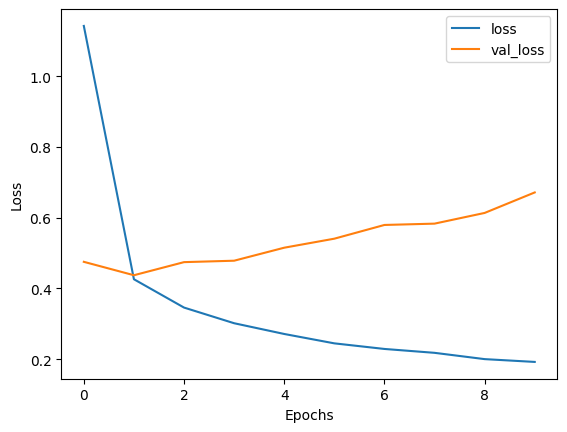

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend(['loss', 'val_loss'])

plt.show()
